# Project 2

## Project description

The cells that line blood vessels elongate and align with the direction of the blood flow. The cells in submission S-BIAD1435 have been treated with different drugs (“Figuer 5D-G- Immunofluorescent images used to train CellPose to analyze elongation and alignment in experiments associated with Figure B,C” dataset). The goal of this project is to investigate whether these drugs affect the ability of endothelial cells to respond to blood flow. Using cell segmentation models such as CellPose, can you compare the elongation and the alignment of the cells between the images?

## Setup

### Google Colab

In [ ]:
!pip install --quiet zarr cellpose

### Import necessary dependencies

In [19]:
import dask.array as da
import zarr
from cellpose import models, plot
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from skimage.measure import regionprops, regionprops_table
import pandas as pd
import seaborn as sns

### Images from S-BIAD1345 (BioImage Archive)

* Entry page: https://www.ebi.ac.uk/biostudies/BioImages/studies/S-BIAD1345 
* License: CC0

Images of cells that underwent different treatments

In [45]:
images = (
    "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD1345/26e86821-a083-4959-aa15-e0671b1df7f6/1070f12e-2a5e-4b9f-ace5-d67b5a89d005.ome.zarr/0", # Nocodazole static
    "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD1345/4079b051-97d4-4905-85fb-fa6841874cac/72fdda5b-2c12-49e6-8d31-1319aedbbb22.ome.zarr/0", # Colchicine static
    "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD1345/7deef0fb-c21a-462a-9b4f-6e142c10a6be/bb159641-600a-467a-9102-5a914028605c.ome.zarr/0", # Colchicine flow
    "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD1345/fdc9c7dd-da28-4959-b820-d89e13a83298/20063ec3-ac82-4f94-bf11-b500115ee62a.ome.zarr/0" # Tubacin static
)

List of treatments per image

In [57]:
treatments = (
    "Nocodazole static+5z-7-oxo", # decrease in tubulin acetylation no flow + depolymerisation drug
    "Colchicine static+5z-7-oxo", # decrease in tubulin acetylation no flow + depolymerisation drug
    "Colchicine flow+5z-7-oxo", # decrease in tubulin acetylation with flow + depolymerisation drug
    "Tubacin static" # increase in tubulin acetylation  no flow
)

### Helper methods

Function to load zarr images

In [8]:
def load_ome_zarr_from_uri(uri, path_key='0'):
    array_uri = f"{uri}/{path_key}"
    
    return da.from_zarr(array_uri)

Function to select a single plane from a multidimensional image

In [9]:
def select_single_plane(array, t, z, c):
    """Select a single plane from a lazy array, load and return it."""

    return array[t, c, z, :, :].compute()

Function to perform analysis. Note: for this CellPose model to work, the diamater of the ROIs has to be adjusted

In [10]:
def measure_nuclear_properties(single_plane_bia,model):
    cellpose_masks_bia, flows_bia, styles, diams = model.eval(single_plane_bia, diameter=400, channels=[0, 0])
    regions = regionprops(cellpose_masks_bia)
    props = regionprops_table(
        cellpose_masks_bia,
        properties=('area','orientation','feret_diameter_max', 'axis_major_length', 'axis_minor_length'),
    )
    angle_in_degrees = props['orientation'] * (180/np.pi) + 90 
    ar = props['axis_major_length']/props['axis_minor_length']
    props.update({'aspect_ratio': ar})
    props.update({'orientation_in_degrees': angle_in_degrees})
    return cellpose_masks_bia, flows_bia, props

### Load CellPose trained model

In [11]:
model = models.Cellpose(gpu=False, model_type='cyto3')

### Analyse images

time = 1, channels = 3, z = 1, y = 2048, x = 2448


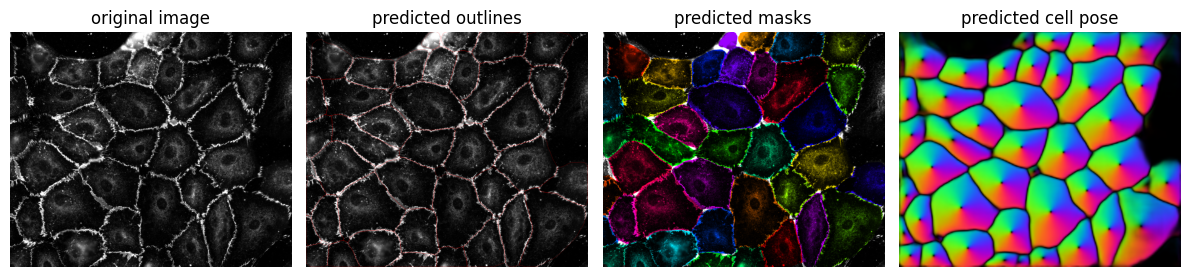

time = 1, channels = 3, z = 1, y = 2048, x = 2448


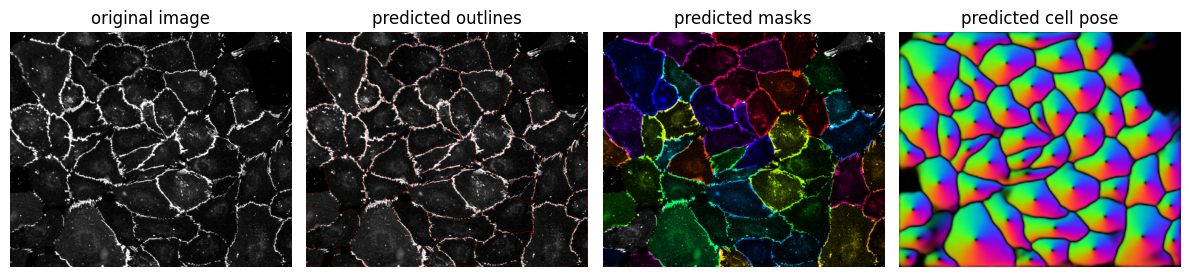

time = 1, channels = 3, z = 1, y = 2048, x = 2448


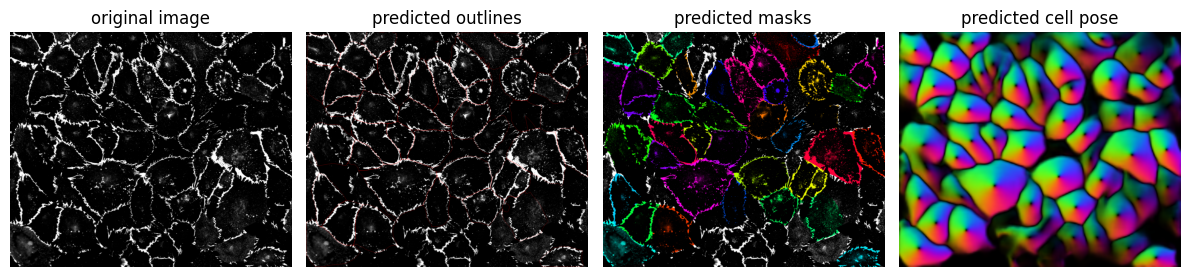

time = 1, channels = 3, z = 1, y = 2048, x = 2448


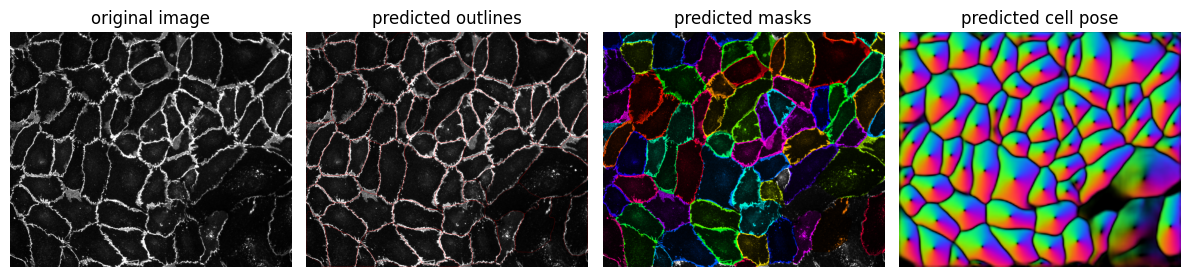

In [60]:
results = pd.DataFrame()
for bia_uri, condition in zip(images,treatments):
    bia_array = load_ome_zarr_from_uri(bia_uri)
    print("time = {}, channels = {}, z = {}, y = {}, x = {}".format(*bia_array.shape))

    single_plane_bia = select_single_plane(bia_array, t=0, z=0, c=0)

    # Measure cell properties
    cellpose_masks_bia, flows_bia, props = measure_nuclear_properties(single_plane_bia,model)

    # add new column to properties dictionary to identify each image for plotting
    t_list = np.full(len(props['area']), condition).tolist()
    props['treatment'] = t_list
    df = pd.DataFrame.from_dict(props)
    results = pd.concat([results, df])
    # Plot example segmentation for the image
    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, single_plane_bia, cellpose_masks_bia, flows_bia[0], channels=[0, 0])
    plt.tight_layout()
    plt.show()



### Plot area

<Axes: xlabel='area', ylabel='treatment'>

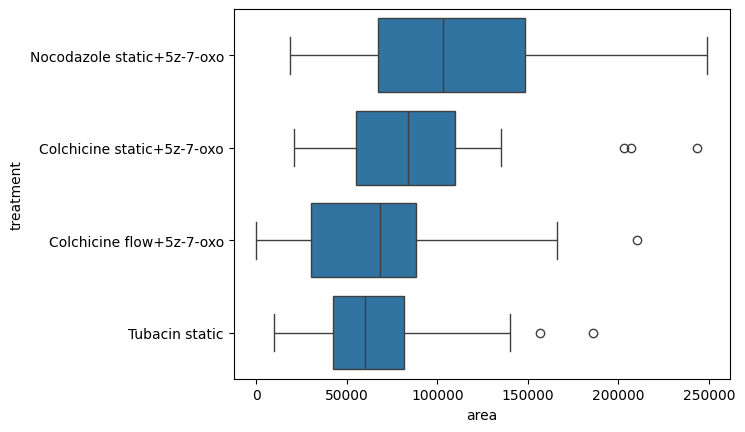

In [62]:
sns.boxplot(data=results, y="treatment", x="area")

### Plot aspect ratio

(0.0, 4.0)

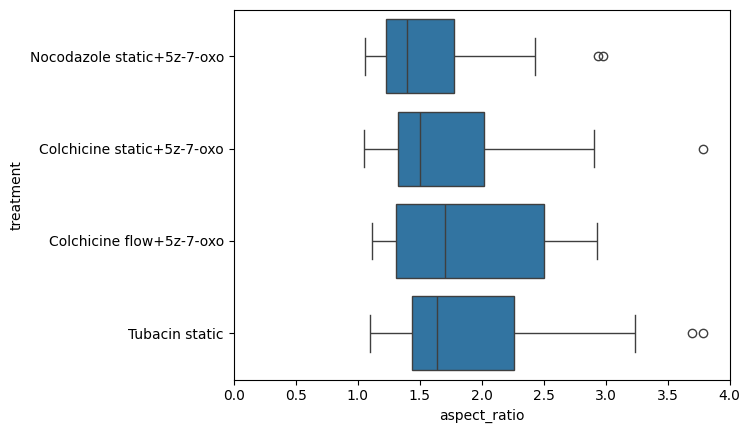

In [64]:
ax = sns.boxplot(data=results, y="treatment", x="aspect_ratio")
ax.set_xlim([0, 4])

### Plot orientation

<Axes: xlabel='orientation_in_degrees', ylabel='treatment'>

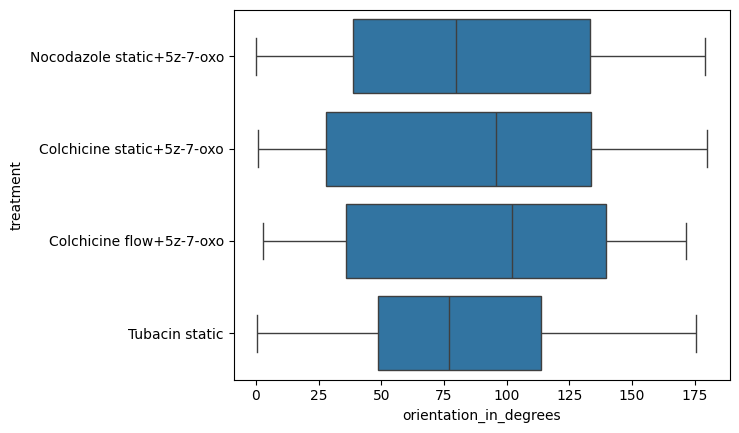

In [65]:
sns.boxplot(data=results, y="treatment", x="orientation_in_degrees")

### Plot Feret's diameter

<Axes: xlabel='feret_diameter_max', ylabel='treatment'>

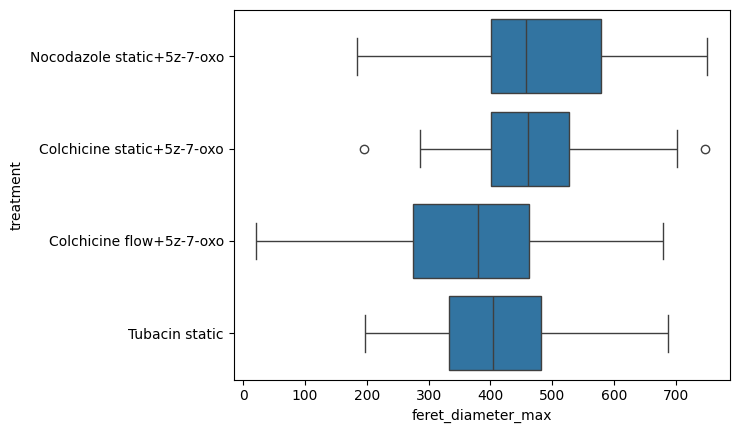

In [66]:
sns.boxplot(data=results, y="treatment", x="feret_diameter_max")

conclusion: In the absence of flow, tubacin treatment alone is not enough to cause effects on cell orientation or elongation compared to cells treated with an acetylation inhibitor and MT depolymerisation drugs. Similarly, the effects that flow has in cell elongation and orientation are supressed by colchicine treatment